# "Global Biodiversity" Widget

This widget is a horizontally oriented histogram, breaking sub regions into buckets of 'Very High' to 'Very Low' Intactness or Significance.

Due to the heavily qualitative nature of the data we are unable to quote any numerical values, nor make direct comparisons between subregions.

In the face of that the histogram will only display the percentage of subregions that fall into each bucket as a percentage.

Along side the histogram 

User Variables:

1. Admin-0, -1 and -2 region
2. number of subregions or %
3. Biodiversity Intactness or Significance

On Hover:

When a user hovers on a bar the dynamic sentence should change to reflect the value of the bar.

Tabs: ['Conservation']

In [1]:
import os
import ee
import json
import requests
import requests_cache
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as stats

ee.Initialize()

In [2]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [53]:
# Make the query and return data
def biodiversity_query(adm0=None):
    """Fetches subregions within an adm1, adm0, or if none are selected, all data (global)"""
                  
    if adm0:
        print('Request for  adm1 areas')
        sql = (f"SELECT iso, adm1, sum(area) as area, "
               "sum(significance_total) AS sig, sum(intactness_total) AS int "
               f"FROM global_biodiversity_table "
               f"WHERE iso = '{adm0}' "
               "GROUP BY iso, adm1")
        
    else:
        print('Request adm0 areas')
        sql = (f"SELECT iso, sum(area) as area, "
               "sum(significance_total) AS sig, sum(intactness_total) AS int "
               f"FROM global_biodiversity_table "
               "GROUP BY iso")
    
    account = 'wri-01'
    urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

    sql = {"q": sql}
    r = requests.get(urlCarto, params=sql)
    print(r.url,'\n')
    # pprint(r.json())
    data = r.json().get('rows')
    
    return data

In [56]:
adm0 = None

data = biodiversity_query(adm0=adm0)

Request adm0 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+GROUP+BY+iso 



In [57]:
"""NOTE significance is exponential and ranges from 0 to 1.73e9
        intactness is linear and ranges from 0.37e9 to -3.17e9"""

data[0:3]

[{'area': 22111665731.4525,
  'int': -43091664.7444239,
  'iso': 'BLZ',
  'sig': 186736529.119748},
 {'area': 140281129471.352,
  'int': -4773897473.97335,
  'iso': 'BGD',
  'sig': 117727281.708589},
 {'area': 7860417202.66774, 'int': 0, 'iso': 'ATF', 'sig': 86.335124714994}]

# Get Global Stats

In [78]:
# Order all data and convert to numpy arrays in order to calculate basic stats

ints = np.array(sorted([-d.get('int')/d.get('area') for d in data if d.get('int')]))
sigs = np.array(sorted([math.log(d.get('sig')/d.get('area'),10) for d in data if d.get('sig')]))

int_mean = np.mean(ints)
sig_mean = np.mean(sigs)

int_std = np.std(ints)
sig_std = np.std(sigs)

int_min = min(ints)
sig_min = min(sigs)

int_max = max(ints)
sig_max = max(sigs)


In [79]:
int_mean, int_std, int_min, int_max, len(ints)

(0.013554878351228036,
 0.013541971465133173,
 -0.0014040467121138754,
 0.052339550895002786,
 191)

In [80]:
sig_mean, sig_std, sig_min, sig_max, len(sigs)

(-3.2689822231225887,
 1.7958513415646264,
 -12.41119405534762,
 0.02518224073583945,
 218)

### Nature of the data

In [85]:
binwidth = int_std/2

(array([ 81.,  28.,  25.,  15.,  14.,  19.,   6.,   3.]),
 array([-0.00140405,  0.00536694,  0.01213792,  0.01890891,  0.0256799 ,
         0.03245088,  0.03922187,  0.04599285,  0.05276384]),
 <a list of 8 Patch objects>)

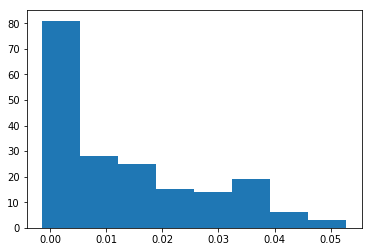

In [86]:
plt.hist(ints, bins=np.arange(min(ints), max(ints) + binwidth, binwidth))

In [87]:
binwidth = sig_std/2

(array([  1.,   2.,   1.,   1.,   2.,   1.,   4.,  11.,  10.,  48.,  63.,
         47.,  21.,   6.]),
 array([-12.41119406, -11.51326838, -10.61534271,  -9.71741704,
         -8.81949137,  -7.9215657 ,  -7.02364003,  -6.12571436,
         -5.22778869,  -4.32986302,  -3.43193735,  -2.53401168,
         -1.63608601,  -0.73816034,   0.15976534]),
 <a list of 14 Patch objects>)

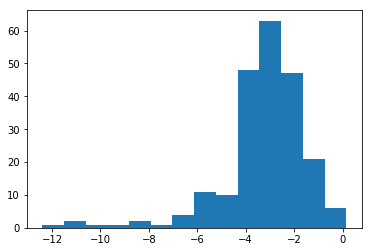

In [88]:
plt.hist(sigs, bins=np.arange(min(sigs), max(sigs) + binwidth, binwidth))

# NOTE

- log(significance) seems to be normally distributed with a spike of low-significance regions
- intactness is more Maxwell-Boltzmann and has a long tail in the high-end values...
- INstead of using standard deviations as bounds, use percentiles.

In [89]:
# Calculate percentile values (somewhat arbitrary and can be tweaked)
percentiles = [10, 25, 75, 90]

In [90]:
int_perc = [int_min]
sig_perc = [sig_min]
for p in percentiles:
    int_perc.append(np.percentile(ints, p))
    sig_perc.append(np.percentile(sigs, p))
    
int_perc.append(int_max)
sig_perc.append(sig_max)

In [91]:
# Percentile values for intacteness and significance
int_perc[1:-1], sig_perc[1:-1]

([0.00015267099387302624,
  0.0024074785194902158,
  0.022754608585611132,
  0.034339105523731803],
 [-5.2646716264414586,
  -3.7595154633661956,
  -2.2457416116059994,
  -1.3721143303681893])

(array([ 19.,  29.,  95.,  28.,  20.]),
 array([-0.00140405,  0.00015267,  0.00240748,  0.02275461,  0.03433911,
         0.05233955]),
 <a list of 5 Patch objects>)

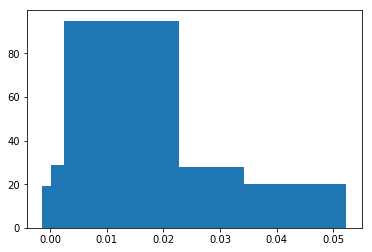

In [92]:
plt.hist(ints, bins=int_perc)

(array([  22.,   33.,  108.,   33.,   22.]),
 array([-12.41119406,  -5.26467163,  -3.75951546,  -2.24574161,
         -1.37211433,   0.02518224]),
 <a list of 5 Patch objects>)

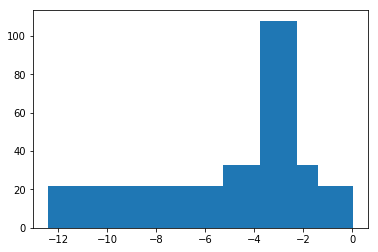

In [93]:
plt.hist(sigs, bins=sig_perc)

- Get a list of sub regions' in and sig values
- build a distribution
- pick bounds
- bucket into 'V. High', 'High', 'Normal', 'Low', 'V. Low'

# Widget

### To do

1. Get mean and std
2. create buckets from these
3. count number in each bucket
4. calc percentage


In [94]:
int_perc[1:-1]

[0.00015267099387302624,
 0.0024074785194902158,
 0.022754608585611132,
 0.034339105523731803]

In [95]:
sig_perc[1:-1]

[-5.2646716264414586,
 -3.7595154633661956,
 -2.2457416116059994,
 -1.3721143303681893]

In [116]:
def getLocalStats(data, metric='int'):
    if metric == 'int':
        values = [-d.get('int')/d.get('area') for d in data if d.get('int')]
    elif metric == 'sig':
        values = [math.log(d.get('sig')/d.get('area'),10) for d in data if d.get('sig')]
    
    mean = np.mean(values)
    std = np.std(values)
    
    return {'mean': mean, 'std': std}

In [109]:
def getHistogram(data):
    
    metrics = ['int', 'sig']
    tmp = {} 

    for metric in metrics:
        
        counts = {

            'very high': 0,
            'high': 0,
            'normal': 0,
            'low': 0,
            'very low': 0

        }
        
        for d in data:
            if metric == 'int':
                value = -d.get(metric)
                percentile = int_perc[1:-1]
            elif metric == 'sig' and d.get('sig'):
                value = math.log(d.get('sig'))
                percentile = sig_perc[1:-1]

            if (value > percentile[3]):
                counts['very high'] += 1
            elif (value > percentile[2]) and (value <= percentile[3]):
                counts['high'] += 1
            elif (value > percentile[1]) and (value <= percentile[2]):
                counts['normal'] += 1
            elif (value > percentile[0]) and (value <= percentile[1]):
                counts['low'] += 1
            elif (value <= percentile[0]):
                counts['very low'] += 1

        total = sum(counts.values())
    
        tmp[metric] = {k: round(100 * v / total, 2) for k,v in counts.items()}
    
    return tmp


In [110]:
getHistogram(data)

{'int': {'high': 0.0,
  'low': 0.0,
  'normal': 0.0,
  'very high': 100.0,
  'very low': 0.0},
 'sig': {'high': 0.0,
  'low': 0.0,
  'normal': 0.0,
  'very high': 100.0,
  'very low': 0.0}}

# Dynamic Sentence

In [111]:
def getSentence(hist, selected, metric): 
    
    pprint(hist)
    
    if(metric == 'int'):
        label = 'intacteness'
    elif(metric == 'sig'):
        label = 'signficance'

    areaId_to_name = None
    if adm2:
        tmp = get_admin2_json(iso=adm0, adm1=adm1)
        areaId_to_name ={}
        for row in tmp:
            areaId_to_name[row.get('adm2')] = row.get('name')
    if adm1 and not adm2:
        tmp = get_admin1_json(iso=adm0)
        areaId_to_name={}
        for row in tmp:
            areaId_to_name[row.get('adm1')] = row.get('name')

    if not adm0 and  not adm1 and not adm2:
        title = ("countries globally")
    if adm0 and not adm1 and not adm2:
        title = (f"regions in {iso_to_countries[adm0]}")
    if adm0 and adm1 and not adm2: 
        title = (f"subregions in {areaId_to_name[adm1]}")

    print("")
    print(f"Around {hist[metric][selected]}% of {title} have a ",end="")
    print(f"{selected} degree of biodiversity {label} on average.", end="")


# Examples

In [112]:
adm0 = 'IDN'

data = biodiversity_query(adm0=adm0)
hist = getHistogram(data)
getSentence(hist, 'very high','int')

Request for  adm1 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27IDN%27+GROUP+BY+iso%2C+adm1 

{'int': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 88.24,
         'very low': 11.76},
 'sig': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 100.0,
         'very low': 0.0}}

Around 88.24% of regions in Indonesia have a very high degree of biodiversity intacteness on average.

In [113]:
adm0 = 'BRA'

data = biodiversity_query(adm0=adm0)
hist = getHistogram(data)
getSentence(hist, 'low','sig')

Request for  adm1 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27BRA%27+GROUP+BY+iso%2C+adm1 

{'int': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 81.48,
         'very low': 18.52},
 'sig': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 100.0,
         'very low': 0.0}}

Around 0.0% of regions in Brazil have a low degree of biodiversity signficance on average.

In [114]:
adm0 = 'GBR'

data = biodiversity_query(adm0=adm0)
hist = getHistogram(data)
getSentence(hist, 'low','sig')

Request for  adm1 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+adm1%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+WHERE+iso+%3D+%27GBR%27+GROUP+BY+iso%2C+adm1 

{'int': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 100.0,
         'very low': 0.0},
 'sig': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 100.0,
         'very low': 0.0}}

Around 0.0% of regions in United Kingdom have a low degree of biodiversity signficance on average.

In [115]:
adm0 = None

data = biodiversity_query(adm0=adm0)
hist = getHistogram(data)
getSentence(hist, 'high','int')

Request adm0 areas
https://wri-01.carto.com/api/v2/sql?q=SELECT+iso%2C+sum%28area%29+as+area%2C+sum%28significance_total%29+AS+sig%2C+sum%28intactness_total%29+AS+int+FROM+global_biodiversity_table+GROUP+BY+iso 

{'int': {'high': 0.0,
         'low': 0.0,
         'normal': 0.0,
         'very high': 81.17,
         'very low': 18.83},
 'sig': {'high': 0.45,
         'low': 0.0,
         'normal': 0.0,
         'very high': 99.55,
         'very low': 0.0}}

Around 0.0% of countries globally have a high degree of biodiversity intacteness on average.